In [9]:
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import *
import numpy as np

### Define variables

In [10]:
DATA_PATH = settings.data_path
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2016-12-21'
END_DATE = '2021-04-20'
MASK_PATH = "water_mask.json"

### Make instance of data generator

In [4]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH)

### Load sample day

In [5]:
sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

### Load water mask

In [6]:
mask_height, mask_width, _ = sample_day.rgb.shape
mask = Mask(MASK_PATH, mask_width, mask_height)

### Display mask in sample day

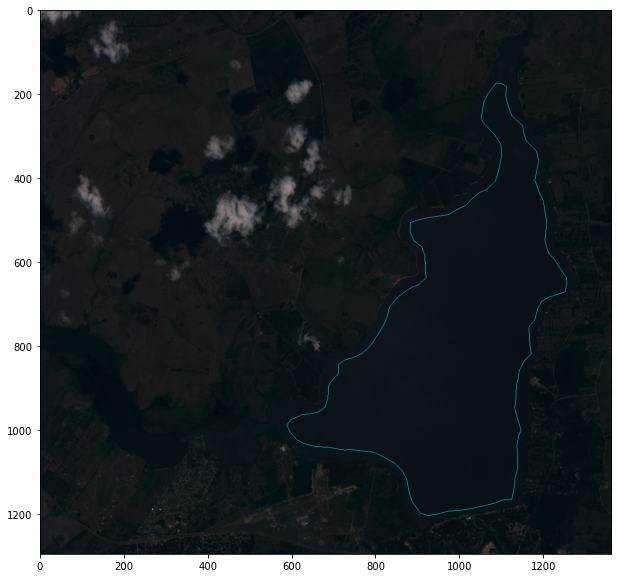

In [5]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mask.display_mask_contour(sample_day.rgb))
plt.show()

### Tag valid and invalid data

In [22]:
from IPython.display import clear_output
import time

for day in data_generator:
    print(day.date)
    print(day.metadata)
    current_metadata = day.metadata
    if current_metadata != {}:
        time.sleep(0.1)
        clear_output(wait=True)
        continue
    # display rgb of day
    fig = plt.figure(figsize=(20,10))
    plt.imshow(mask.display_mask_contour(day.rgb))
    plt.show()
    # get user input
    user_input = input()
    # process input
    if user_input == "y":
        status = True
    elif user_input == "n":
        status = False
    else:
        status = "N/A"
    # overwrite with changes
    with open(day.metadata_path, 'w') as fp:
        current_metadata["valid"] = status
        json.dump(current_metadata, fp)
    clear_output(wait=True)

2021-03-26 13:42:09
{'valid': False}


## Clustering

### Make NDCI numpy array dataset

In [11]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], len(data_generator)))
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=len(data_generator))
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)
pbar.close()

100%|██████████| 75/75 [00:48<00:00,  1.56it/s]


### Make clustering dataset

In [ ]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 255:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)
pbar.close()

### Save to json

In [9]:
json_dictionary = {}
json_dictionary["data"] = clustering_dataset
json_dictionary["positions"] = indexes
json_dictionary["dates"] = dates_list

with open("clustering_dataset.json", 'w') as f:
    json.dump(json_dictionary, f)

### Load clustering dataset

In [12]:
import json

with open("clustering_dataset.json") as f:
    clustering_data = json.load(f)

### Fit clustering data

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
import numpy as np

X = clustering_data["data"]
n_clusters = 3

clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
#clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
#clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize').fit(X)

### Display clusters

cluster labels: [0, 1, 2]


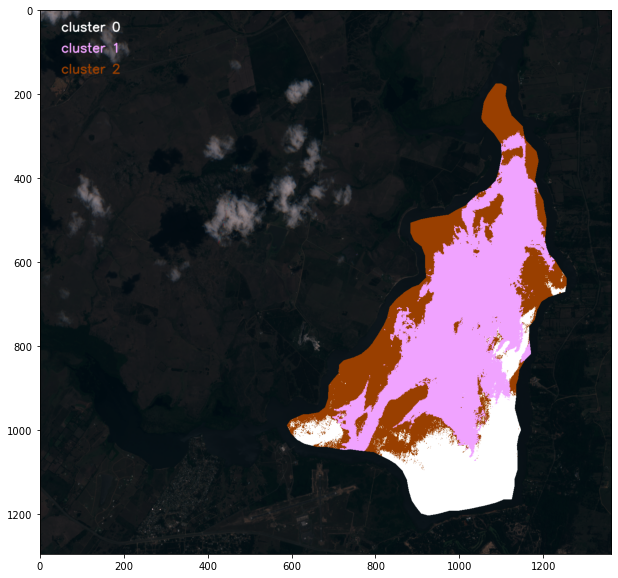

In [14]:
from process_sentinel2 import *
import cv2

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
final_img = sample_day.rgb.copy()
labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254

#white, pink, brown, green, 
clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153]]

unique_labels = list(set(clustering.labels_))
print("cluster labels:", unique_labels)

# here I'm iterating over a list containing the label of every pixel in the lagoon
for i, label in enumerate(clustering.labels_):
    label_position = clustering_data["positions"][i]
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]
    labels_arr[label_position[0], label_position[1]] = int(label)

# draw legends
legend_position = {"x": 50, "y": 50}
for label in unique_labels:
    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
    legend_position["y"] = legend_position["y"] + 50    

fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
plt.show()

### Get mean and std of every cluster for every day

In [15]:
H, W, D = ndci_dataset_array.shape

results = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        label_mean = np.mean(label_ndci_values)
        label_std = np.std(label_ndci_values)
        
        day_results[label] = {"mean": label_mean, "std": label_std}
    results.append(day_results)
    pbar.update(1)            
pbar.close()

100%|██████████| 75/75 [00:18<00:00,  3.99it/s]


# Visualization

### Time series of NDCI mean

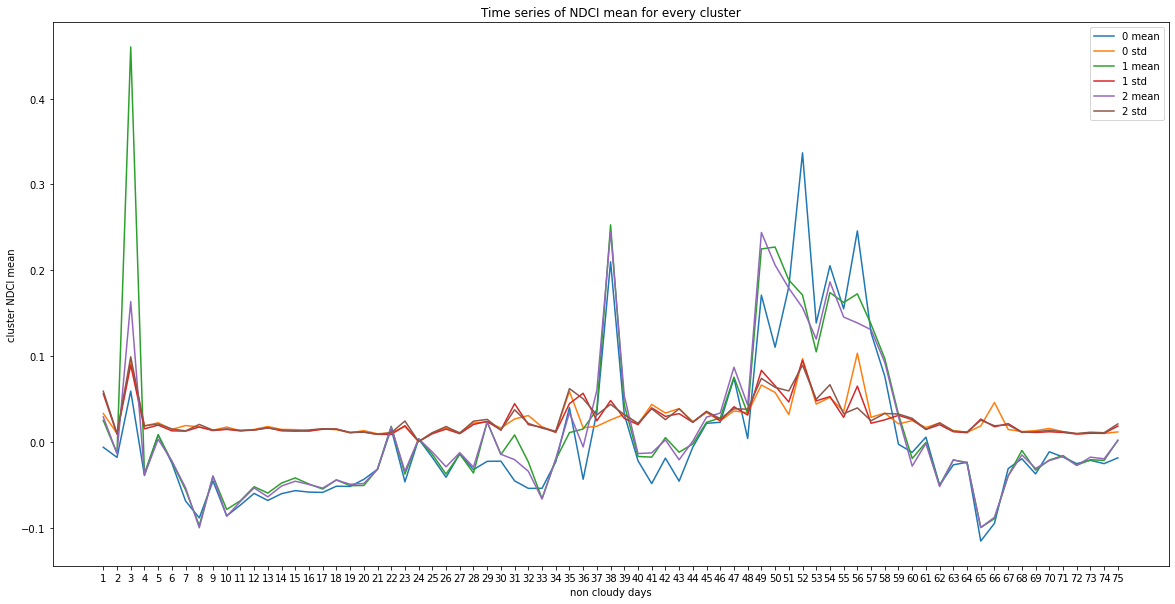

In [16]:
import matplotlib.pyplot as plt

X = range(1, len(results)+1)
fig = plt.figure(figsize=(20,10))
for label in unique_labels:
    label_means = [d[label]["mean"] for d in results]
    label_stds = [d[label]["std"] for d in results]
    plt.plot(X, label_means, label=str(label) + " mean")
    plt.plot(X, label_stds, label=str(label) + " std")

plt.xlabel('non cloudy days')
plt.xticks(np.arange(1, len(results)+1, 1.0))
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean')
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

### Box plot

100%|██████████| 75/75 [00:18<00:00,  4.09it/s]


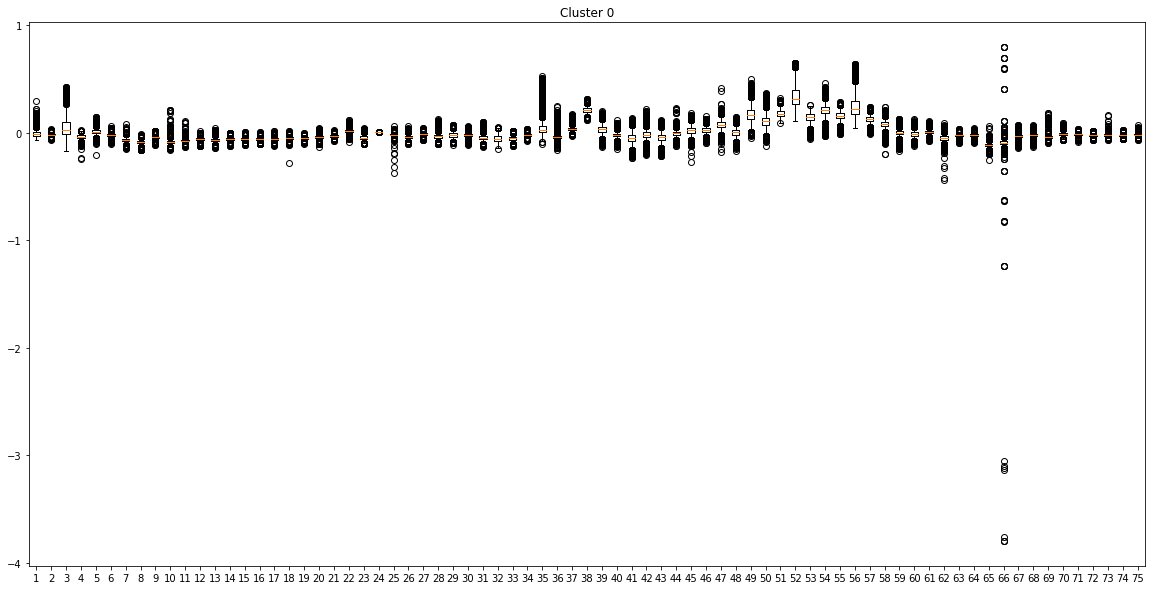

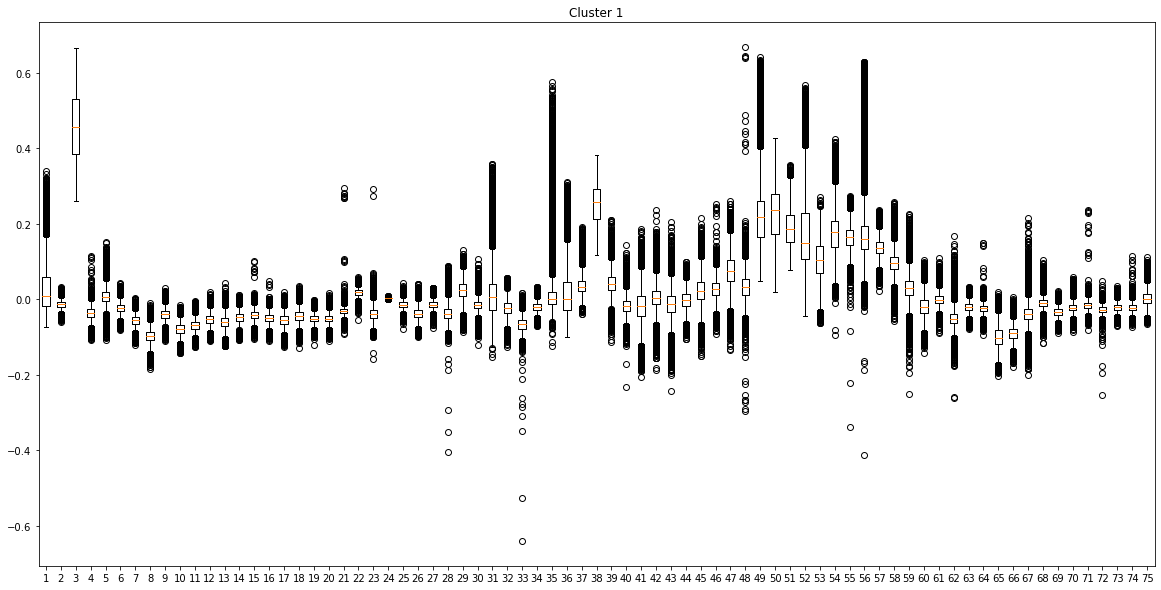

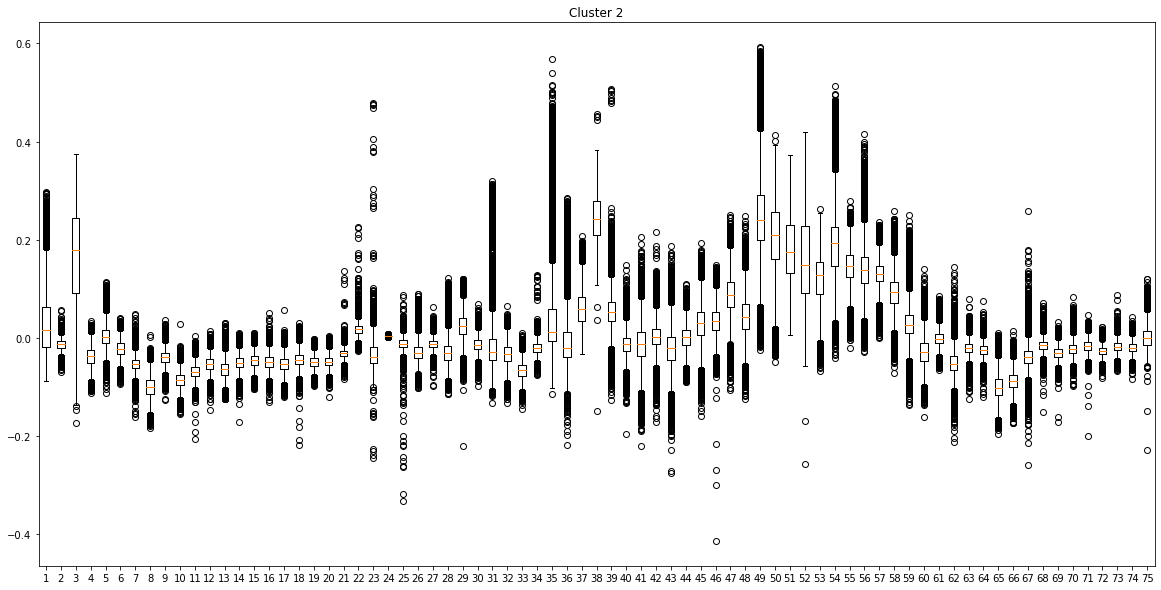

In [17]:
import matplotlib.pyplot as plt

H, W, D = ndci_dataset_array.shape

results_box = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        day_results[label] = label_ndci_values
    results_box.append(day_results)
    pbar.update(1)            
pbar.close()

for label in unique_labels:
    fig = plt.figure(figsize=(20,10))
    plt.title("Cluster " + str(label))
    boxplot_output = plt.boxplot([day[label] for day in results_box])
    plt.show()

### Visualize rgb from day in particular

2017-12-29


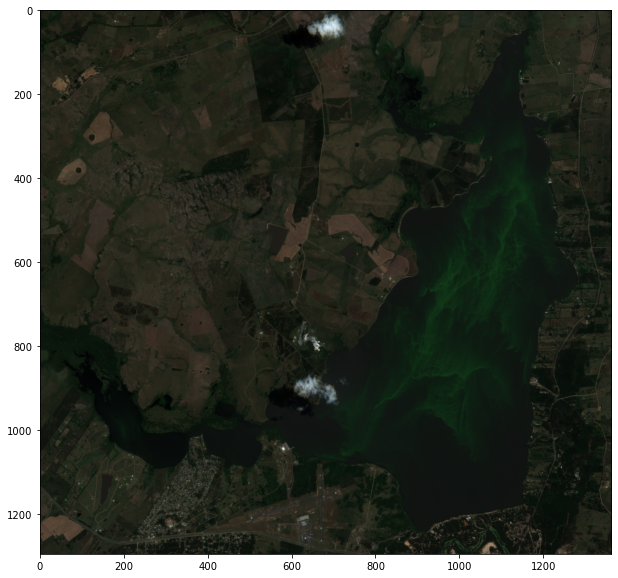

In [18]:
#DATE = "2021-01-25"
DATE = results[2]["date"]
print(DATE)

day_data = DayData(os.path.join(settings.data_path, DATE, "acolite_output"))
fig = plt.figure(figsize=(20,10))
plt.imshow(day_data.rgb)
plt.show()